In [1]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

# Общая информация

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска. Данные находяься в файле 'stud_math.csv'.
Задача - создать модель, предсказывающую результаты госэкзамена (score) по математике для каждого ученика школы

Описание признаков:
* 1 school — аббревиатура школы, в которой учится ученик
* 2 sex — пол ученика ('F' - женский, 'M' - мужской)
* 3 age — возраст ученика (от 15 до 22)
* 4 address — тип адреса ученика ('U' - городской, 'R' - за городом)
* 5 famsize — размер семьи('LE3' <= 3, 'GT3' >3)
* 6 Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
* 7 Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
* 8 Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
* 9 Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не * работает, 'other' - другое)
* 10 Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
* 11 reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
* 12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
* 13 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
* 14 studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
* 15 failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
* 16 schoolsup — дополнительная образовательная поддержка (yes или no)
* 17 famsup — семейная образовательная поддержка (yes или no)
* 18 paid — дополнительные платные занятия по математике (yes или no)
* 19 activities — дополнительные внеучебные занятия (yes или no)
* 20 nursery — посещал детский сад (yes или no)
* 21 higher — хочет получить высшее образование (yes или no)
* 22 internet — наличие интернета дома (yes или no)
* 23 romantic — в романтических отношениях (yes или no)
* 24 famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
* 25 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)
* 26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
* 27 health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
* 28 absences — количество пропущенных занятий
* 29 score — баллы по госэкзамену по математике

# Функции для обработки данных

In [2]:
def describe_categorical_var(series):
    """
    Печатает значения, частоту вхождения, 
    кол-во пропущенных значений категориальной переменной
    """
    print(series.value_counts().head(10), '\n')
    print(series.value_counts(normalize=True).head(), '\n')
    print('Column has {} unique values'.format(series.nunique()))
    print('Column has {} ({}%) missing values\n'.
          format(series.isnull().sum(), series.isnull().sum()/len(series)))


In [3]:
def describe_numerical_var(series):
    """
    Печатает значения, частоту вхождения, 
    кол-во пропущенных значений, IQR, выбросы и распределение числовой переменной 
    """
    p75 = series.quantile(0.75)
    p25 = series.quantile(0.25)
    IQR = p75 - p25
    series.hist()
    print(series.describe(), '\n')
    print('IQR = {}'.format(IQR))
    print('Outliers: {} and {}\n'.format(p25 - 1.5*IQR, p75 + 1.5*IQR))
    print('Column has {} ({}%) missing values\n'.
          format(series.isnull().sum(), series.isnull().sum()/len(series)))


In [4]:
# прочитаем данные
unicef = pd.read_csv('stud_math.csv')
unicef.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [5]:
print('В датасете {} строк и {} столбцов.'.format(unicef.shape[0], unicef.shape[1]))
print('В датасете {} столбцов с пустыми значениями.'.format(unicef.isnull().any().sum()))

В датасете 395 строк и 30 столбцов.
В датасете 27 столбцов с пустыми значениями.


In [6]:
# создадим датафрейм для работы и переименуем столбцы, чтобы все было в одном стиле
df = unicef.rename(columns={'Pstatus': 'p_status', 'Medu': 'm_edu', 'Fedu': 'f_edu', 
                            'Mjob': 'm_job', 'Fjob': 'f_job', 'studytime, granular': 'studytime_gran'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   school          395 non-null    object 
 1   sex             395 non-null    object 
 2   age             395 non-null    int64  
 3   address         378 non-null    object 
 4   famsize         368 non-null    object 
 5   p_status        350 non-null    object 
 6   m_edu           392 non-null    float64
 7   f_edu           371 non-null    float64
 8   m_job           376 non-null    object 
 9   f_job           359 non-null    object 
 10  reason          378 non-null    object 
 11  guardian        364 non-null    object 
 12  traveltime      367 non-null    float64
 13  studytime       388 non-null    float64
 14  failures        373 non-null    float64
 15  schoolsup       386 non-null    object 
 16  famsup          356 non-null    object 
 17  paid            355 non-null    obj

Видим, что у нас относительно небольшой датасет, почти в каждом столбце есть пропуски. Постараемся беречь данные и восстановить их там, где это возможно.

In [7]:
# создадим список категориальных и числовых признаков
categorical_columns = df.select_dtypes(include='object').columns.to_list() + ['m_edu', 
        'f_edu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'health', 'studytime_gran']
numeric_columns = ['age', 'absences', 'score']

# проверим, что никакой из столбцов не пропустили
print(len(categorical_columns) + len(numeric_columns))

30


# Исследование и преобразование признаков

### Предсказываемый столбец

В первую очередь посмотрим на столбец, который собираемся предсказывать

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64 

IQR = 30.0
Outliers: -5.0 and 115.0

Column has 6 (0.015189873417721518%) missing values



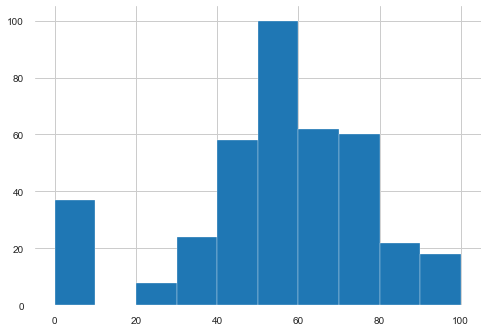

In [8]:
describe_numerical_var(df['score'])

Видим две вещи:
1) есть 6 учеников вообще без оценки. Удалим этих учеников, т.к. это столбец, который предстказываем

2) есть группа учеников с оценкой = 0. Скорее всего это те ученики, которые не явились на экзамен. Не уверен, что их наличие корректно скажется на предсказании оценки, я бы скорее разделил задачу на два типа:
* предсказание оценки для явившихся на экзамен учеников ( 0 < оценка <= 100)
* предсказание того, что ученик не явится на экзамен (оценка = 0)

In [9]:
df = df.dropna(subset=['score'])

### Категориальные признаки

In [10]:
# так и не понял, можно ли пользоваться pandas_profiling, так что 
# для закрепления материала пройдемся по столбцам вручную

for column in categorical_columns:
    print('*** Analyzing \'{}\' column ***'.format(column))
    describe_categorical_var(df[column])

*** Analyzing 'school' column ***
GP    344
MS     45
Name: school, dtype: int64 

GP    0.884319
MS    0.115681
Name: school, dtype: float64 

Column has 2 unique values
Column has 0 (0.0%) missing values

*** Analyzing 'sex' column ***
F    204
M    185
Name: sex, dtype: int64 

F    0.524422
M    0.475578
Name: sex, dtype: float64 

Column has 2 unique values
Column has 0 (0.0%) missing values

*** Analyzing 'address' column ***
U    291
R     83
Name: address, dtype: int64 

U    0.778075
R    0.221925
Name: address, dtype: float64 

Column has 2 unique values
Column has 15 (0.038560411311053984%) missing values

*** Analyzing 'famsize' column ***
GT3    255
LE3    107
Name: famsize, dtype: int64 

GT3    0.70442
LE3    0.29558
Name: famsize, dtype: float64 

Column has 2 unique values
Column has 27 (0.06940874035989718%) missing values

*** Analyzing 'p_status' column ***
T    308
A     36
Name: p_status, dtype: int64 

T    0.895349
A    0.104651
Name: p_status, dtype: float64 



1) 'school' - все ок, нет пропусков, всего два уникальных значения. Есть сильный перекос в сторону одной из школ. В дальнейшем надо проверить - возможно, это школа находится в удалении и в нее, например, ходят преимущественно дети за городом. 

2) 'sex' - все ок, нет пропусков, всего два уникальных значения. Девочек немного больше, чем мальчиков.

3) 'address' - есть пропуски, перекос в сторону городских жителей (U). Пропуски заполним модой.

4) 'famsize' - есть пропуски, перекос в сторону, где кол-во членов семьи <= 3. Пропуски заполним модой.

5) 'p_status' - есть пропуски. Воспользуемся 'famrel' для заполнения пропусков, там, где famrel <=2 заполним 'A', иначе - заполним модой ('T')

6) 'm_job' - пропуски заполним модой, тем более это значение 'other'

7) 'f_job' - пропуски заполним модой, тем более это значение 'other'

8) 'm_edu' - пропуски заполним модой

9) 'f_edu' - пропуски заполним модой, значение 40 заменим 4.0

10) 'reason' - пропуски заполним модой

11) 'guardian' - пропуски заполним модой

12) 'traveltime' - пропуски заполним модой

13) 'studytime' - пропуски заполним модой

14) 'failures' - пропуски заполним модой, недопустимое значение 4.0 заменим на 0

15) 'schoolsup' - пропуски заполним модой

16) 'famsup' - пропуски заполним модой

17) 'paid' - пропуски заполним модой

18) 'activities' - пропуски заполним модой

19) 'nursery' - пропуски заполним модой

20) 'studytime_gran' - нет описания этого столбца, хотя выглядит он нормально. Распределение точно такое же, как у studytime, скорее всего они идентичны. Надо проверить и удалить.

21) 'higher' - пропуски заполним модой

22) 'internet' - пропуски заполним модой

23) 'romantic' - пропуски заполним модой 

24) 'famrel' - пропуски заполним модой, недопустимое значение -1.0 заменим на 1.0

25) 'freetime' - пропуски заполним модой 

26) 'goout' - пропуски заполним модой 

27) 'health' - пропуски заполним модой 

Анализ признаков показывает, что пропуски редко превышают 10% строк (а чаще - даже ниже). Поэтому просто заменим пропуски на моду (если в дальнейшем нам понадобится улучшение модели - постараемся поискать взаимосвязи). Исправим некорретные данные.

In [11]:
# для 'p_status' попробуем заполнить в зависимости от famrel (плохие отношения - 'A', иначе - мода)
df['p_status'][(df['p_status'].isnull() == True) & (df['famrel'] <= 2)].fillna('A', inplace=True)
df['p_status'].fillna(df['p_status'].mode()[0], inplace=True)

# для остальных столбцов меняем пропуски на моду
for column in categorical_columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [12]:
# исправим ошибки
df.loc[df['f_edu'] == 40.0, 'f_edu'] = 4.0
df.loc[df['failures'] == 4.0, 'failures'] = 0.0
df.loc[df['famrel'] == -1.0, 'famrel'] = 1.0

Есть подозрение, что столбцы 'studytime' и 'studytime_gran' идентичны, проверим:

In [13]:
pd.pivot_table(df, values=['school'], index=['studytime'], columns=['studytime_gran'], aggfunc = 'count')

school                    
studytime_gran  -12.0 -9.0   -6.0   -3.0 
studytime                                
1.0               NaN   NaN    NaN  103.0
2.0               NaN   NaN  196.0    NaN
3.0               NaN  63.0    NaN    NaN
4.0              27.0   NaN    NaN    NaN

Действительно, это идентичные колонки, поэтому можем 'studytime_gran', которой нет в описании, удалить из списка категориальных переменных

In [14]:
#df = df.drop(columns=['studytime_gran'])
categorical_columns.remove('studytime_gran')

### Числовые признаки:

count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64 

IQR = 2.0
Outliers: 13.0 and 21.0

Column has 0 (0.0%) missing values



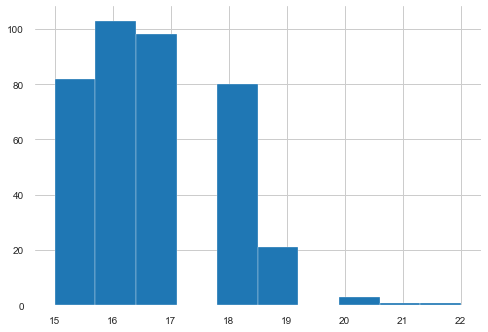

In [15]:
describe_numerical_var(df['age'])

У столбца 'age' нет пропусков. Возраст, равный 22 не будем считать за выброс (хотя технически он больше Q75+1.5 * IQR), т.к. в условии и описании говорится о детях возрастом 15-22. 

count    378.000000
mean       7.320106
std       23.615525
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64 

IQR = 8.0
Outliers: -12.0 and 20.0

Column has 11 (0.028277634961439587%) missing values



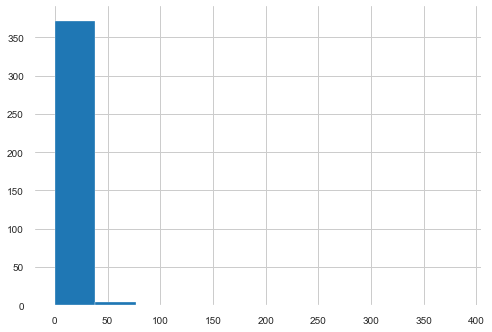

In [16]:
describe_numerical_var(df['absences'])

Видим странное значение у ученика с 385 пропущенными занятиями. Посмотрим на учеников, у которых значение пропущенных занятий попадают в выбросы (Q3 + 1.5 * IQR)

In [17]:
df[df['absences']>=20]

,school,sex,age,address,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,yes,no,yes,no,-6.0,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,3.0,3.0,5.0,54.0,55.0
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,home,mother,2.0,2.0,0.0,yes,yes,yes,no,yes,-6.0,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
118,GP,M,17,R,GT3,T,1.0,3.0,other,other,course,father,3.0,2.0,1.0,no,yes,no,yes,yes,-6.0,yes,yes,no,4.0,2.0,4.0,5.0,20.0,40.0
183,GP,F,17,U,LE3,T,3.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,yes,5.0,3.0,3.0,1.0,56.0,40.0
198,GP,F,17,U,GT3,T,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,no,yes,no,no,yes,-3.0,yes,yes,no,4.0,2.0,4.0,2.0,24.0,90.0
205,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,home,mother,1.0,3.0,1.0,no,yes,yes,no,yes,-9.0,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0
216,GP,F,17,U,GT3,T,4.0,3.0,other,other,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,-6.0,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
237,GP,F,16,U,GT3,T,2.0,1.0,other,other,home,mother,1.0,1.0,0.0,no,yes,no,no,yes,-3.0,yes,yes,yes,4.0,5.0,2.0,5.0,20.0,60.0


Видим, что таких учеников довольно много. К тому же, есть ученики у которых absenses > 200. Возможно, они находились на домашнем обучении. Попробуем увеличить границу выброса

In [18]:
df[df['absences']>60]

,school,sex,age,address,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gran,higher,internet,romantic,famrel,freetime,goout,health,absences,score
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
276,GP,F,18,R,GT3,A,3.0,2.0,other,services,home,mother,2.0,2.0,0.0,no,yes,no,no,no,-6.0,no,yes,yes,4.0,1.0,1.0,5.0,75.0,45.0
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,mother,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0


Отлично, этих учеников мы, пожалуй, исключим

In [19]:
df = df.drop(df[df['absences']>60].index)

count    375.000000
mean       5.586667
std        7.313992
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max       56.000000
Name: absences, dtype: float64 

IQR = 8.0
Outliers: -12.0 and 20.0

Column has 11 (0.02849740932642487%) missing values



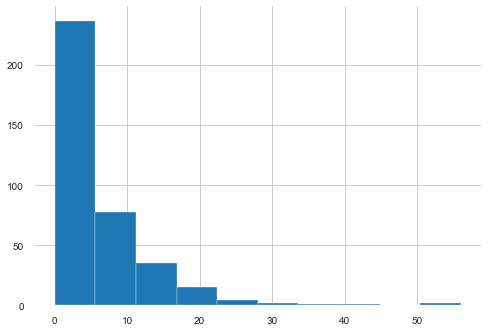

In [20]:
describe_numerical_var(df['absences'])

Видим, что все равно есть группа, где пропусков больше 50. Чтобы избежать перекосов, замени пропуски на медиану.

In [21]:
df['absences'].fillna(df['absences'].median(), inplace=True)

### Корреляционный анализ категориальных признаков

Сначала посмотрим визуально, какие зависимости могут быть между категориальными переменными и 'score' (для учеников, явившихся на экзамен, 'score' > 0)

C:\Users\Insar\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


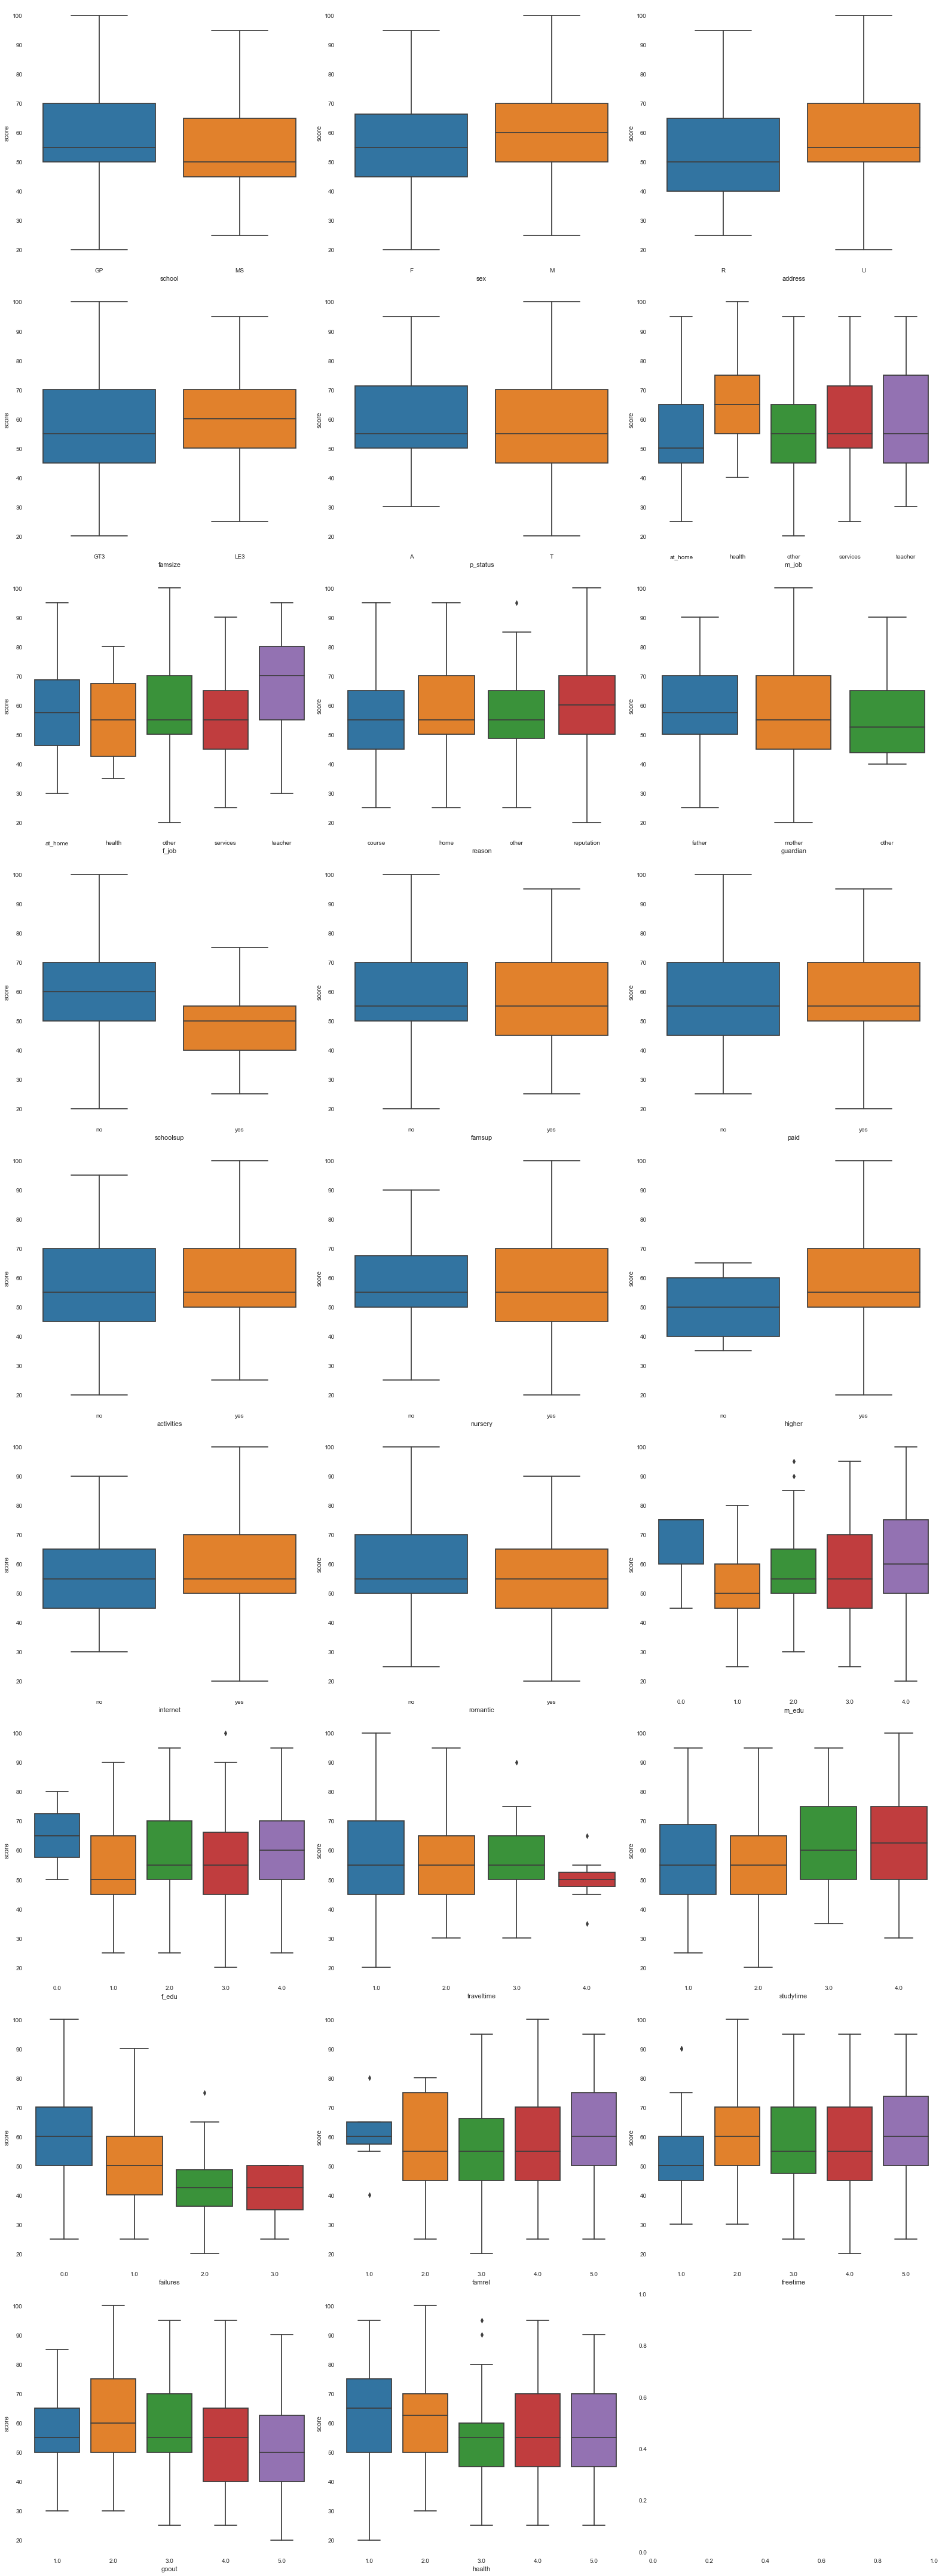

In [22]:
def countplots(df):
    """
    Фунция рисует боксплоты для наших категориальных признаков
    """
    fig, axes = plt.subplots(9, 3, figsize = (22, 60))
    count = 0
    for column_name in categorical_columns:
        ax = axes[count // 3, count % 3]
        df = df.sort_values(by = [column_name])
        sns.boxplot(data = df, x = column_name, y = "score", ax = ax)
        count += 1
    fig.tight_layout() 
    fig.show()

countplots(df[df['score'] > 0])

Визуально трудно выделить все значимые признаки. Проверим тест Стьюдента для каждого из категориальных признаков. При этом фильтруем датасет только по ученикам, которые пришли на экзамен ('score' > 0)

In [23]:
def get_stat_dif(column):
    """
    Функция проверяет значимость с помощью теста Стьюдента,
    Если признак значимо влияет на score, записывает название столбца в model_columns 
    """
    cols = df[column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df[df['score'] > 0].loc[df[column] == comb[0], 'score'], 
                     df[df['score'] > 0].loc[df[column] == comb[1], 'score']).pvalue \
                    <= 0.05/len(combinations_all):  # Учли поправку Бонферони
                print('Найдены статистически значимые различия для колонки', column)
                model_columns.append(column)
                break

In [24]:
model_columns = []  # здесь будем хранить статистически значимые категориальные признаки
for col in categorical_columns:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки m_job
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки m_edu
Найдены статистически значимые различия для колонки f_edu
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки goout


### Корреляционный анализ численных признаков

Сначала посмотрим визуально, какие зависимости могут быть между численными переменными и 'score' (для учеников, явившихся на экзамен, 'score' > 0)

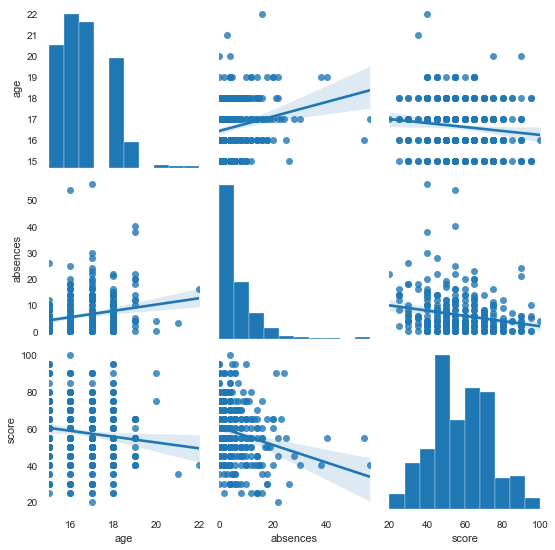

In [25]:
sns.pairplot(df[['age','absences','score']][df['score'] > 0], kind = 'reg')

Для численных признаков проверим корреляцию Пирсона (для учеников, явившихся на экзамен, 'score' > 0)

In [26]:
df[['age','absences','score']][df['score'] > 0].corr()

,age,absences,score
age,1.000000,0.204407,-0.122905
absences,0.204407,1.000000,-0.218858
score,-0.122905,-0.218858,1.000000


Видно, что признаки 'age', 'absences' оказывают влияение на 'score', но достаточно слабое. Тем не менее, попробуем включить их в модель

In [27]:
# формируем итоговый список признаков
model_columns += ['age', 'absences', 'score']
print(model_columns)

['sex', 'address', 'm_job', 'schoolsup', 'm_edu', 'f_edu', 'studytime', 'failures', 'goout', 'age', 'absences', 'score']


In [28]:
# посмотрим итоговый датасет
model_df = df[model_columns][df['score'] > 0]
model_df.head()

,sex,address,m_job,schoolsup,m_edu,f_edu,studytime,failures,goout,age,absences,score
0,F,U,at_home,yes,4.0,4.0,2.0,0.0,4.0,18,6.0,30.0
1,F,U,at_home,no,1.0,1.0,2.0,0.0,3.0,17,4.0,30.0
2,F,U,at_home,yes,1.0,1.0,2.0,3.0,2.0,15,10.0,50.0
3,F,U,health,no,4.0,2.0,3.0,0.0,2.0,15,2.0,75.0
4,F,U,other,no,3.0,3.0,2.0,0.0,2.0,16,4.0,50.0


In [29]:
# проверим, есть ли нулевые переменные
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349 entries, 0 to 394
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sex        349 non-null    object 
 1   address    349 non-null    object 
 2   m_job      349 non-null    object 
 3   schoolsup  349 non-null    object 
 4   m_edu      349 non-null    float64
 5   f_edu      349 non-null    float64
 6   studytime  349 non-null    float64
 7   failures   349 non-null    float64
 8   goout      349 non-null    float64
 9   age        349 non-null    int64  
 10  absences   349 non-null    float64
 11  score      349 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 35.4+ KB


Для использования в модели закодируем категориальные признаки

In [30]:
sex_dict = {'F': 0, 'M': 1}
model_df['sex'] = model_df['sex'].map(sex_dict)

In [31]:
address_dict = {'U': 0, 'R': 1}
model_df['address'] = model_df['address'].map(address_dict)

In [32]:
m_job_dict = {'teacher': 0, 'health': 1, 'services': 2, 'at_home': 3, 'other': 4}
model_df['m_job'] = model_df['m_job'].map(m_job_dict)

In [33]:
schoolsup_dict = {'yes': 1, 'no': 0}
model_df['schoolsup'] = model_df['schoolsup'].map(schoolsup_dict)

In [34]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349 entries, 0 to 394
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sex        349 non-null    int64  
 1   address    349 non-null    int64  
 2   m_job      349 non-null    int64  
 3   schoolsup  349 non-null    int64  
 4   m_edu      349 non-null    float64
 5   f_edu      349 non-null    float64
 6   studytime  349 non-null    float64
 7   failures   349 non-null    float64
 8   goout      349 non-null    float64
 9   age        349 non-null    int64  
 10  absences   349 non-null    float64
 11  score      349 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 35.4 KB


# Выводы

1) В итоговом датасете осталось 349 записи:
- были убраны строки с пустым значением 'score'
- были убраны ученики с выбросами в столбце 'absences'
- убрали учеников со 'score' = 0 т.к. считаю, что это другая задача - предсказание явится или нет ученик на экзамен.

2) Изначально датасет содержал примерно 8% пропусков. Эти данные, в целом, можно безболезненно заменить на моду, числовые признаки - на медиану.

3) Датасет для модели содержит 11 признаков:
- 9 категориальных (sex, address, m_job, schoolsup, m_edu, f_edu, studytime, failures, goout), отобранных по тесту Стьюдента с p_value = 0.05
- 2 количественных (age, absences) - сильной корреляции со 'score' нет, тем не менее решил попробовать использовать их в модели. 

4) В датасете для модели нет пропусков, категориальные данные закодированы в числа. Датасет готов для использования в модели.